In [1]:
import numpy as np
from scipy import sparse
from scipy import stats
from numpy import ma
import functools
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
## Helper functions
matrix_size = (10000, 1000)
nusers = 10000
nitems = 1000
submit_file = "submissions/submission.csv"

def extract_line_data(l):
    us = l.index('_')
    row = int(l[1:us])-1
    com = l.index(',')
    col = int(l[us+2:com])-1
    val = int(l[com+1:l.index('\n')])
    return (row, col, val)
    

def read_data(file_name, test_percentage, seed=123):
    np.random.seed(seed)
    Atr = np.zeros(matrix_size, dtype="int")
    
    with open(file_name, 'r') as fh:
        data = fh.readlines()
    data_size = len(data) - 1
    
    if test_percentage > 0:
        Ats = np.zeros(matrix_size, dtype="int")
        Mts = np.zeros(matrix_size, dtype="bool")
        prob_test = np.random.rand(data_size)

    for i, l in enumerate(data[1:]):
        row, col, val = extract_line_data(l)
        if test_percentage > 0 and prob_test[i] < test_percentage:
            Ats[row, col] = val
            Mts[row, col] = True
        else:
            Atr[row, col] = val
    if test_percentage > 0:
        return (Atr, Ats, Mts)
    return Atr

def calc_score(P, Ats):
    if Ats is None:
        return None
    MAts = np.ma.array(Ats, mask=np.invert(Ats != 0))
    SSE = np.square(P - MAts).sum()
    tot = np.count_nonzero(Ats)
    return np.sqrt(SSE/tot)


def read_mask(file_name):
    with open(file_name, 'r') as fh:
        data = fh.readlines()
    A = np.zeros(matrix_size, dtype="bool")
    for l in data[1:]:
        row, col, _ = extract_line_data(l)
        A[row, col] = True
    return A

def write_predict(pfunc, M, fn):
    with open(fn, 'w') as fh:
        fh.write("Id,Prediction\n")
        for x in range(M.shape[0]):
            for y in range(M.shape[1]):
                if M[x, y] == True:
                    fh.write("r%d_c%d,%f\n" % (x+1, y+1, pfunc(x, y)))

def calc_score_predict(Test, func):
    """Calculate score given a number of desired elements and a prediction function
    """
    if Test is None:
        return 0, None
    Apred = np.zeros_like(Test, dtype="float64")
    indices = np.where(Test != 0)
    for index in range(len(indices[0])):
        u = indices[0][index]
        i = indices[1][index]
        Apred[u, i] = func(u, i)
    score = calc_score(Apred, Test)
    return (score, Apred)

def get_predictor(train, test, func):
    train_indices = np.where(train != 0)
    train_vec = np.zeros(len(train_indices[0]))
    for index in range(len(train_indices[0])):
        u = train_indices[0][index]
        i = train_indices[1][index]
        train_vec[index] = func(u, i)
    if test is not None:
        test_indices = np.where(test != 0)
        test_vec = np.zeros(len(test_indices[0]))
        for index in range(len(test_indices[0])):
            u = test_indices[0][index]
            i = test_indices[1][index]
            test_vec[index] = func(u, i)
    else:
        test_vec = None
    return (train_vec, test_vec)

In [3]:
def plot_scores(tr_scores, ts_scores):
    fig, ax = plt.subplots()
    ax.plot(list(range(1, len(tr_scores)+1)), tr_scores, linestyle="-", linewidth=3, label="Train")
    ax.plot(list(range(1, len(ts_scores)+1)), ts_scores, linestyle="--", linewidth=3, label="Test")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("MSE")
    ax.legend()
    return ax

In [4]:
## Read Data
(Atr, Ats, Mts) = read_data("../data_train.csv", 0.2)
## These are only useful for the submission run.
M = read_mask("../sampleSubmission.csv")
A = read_data("../data_train.csv", 0)

In [5]:
# Set the training matrix. Is either Atr or A
Tr = Atr
Ts = Ats
imp_mask = Ts + Tr
MaTr = np.ma.array(Tr, mask=np.invert(Tr != 0))
MaTs = None #np.ma.array(Ts, mask=np.invert(Ts != 0))

In [6]:
calc_score(Pc, Ts)

NameError: name 'Pc' is not defined

In [7]:
def calc_score(P, Ats):
    if Ats is None:
        return None
    #MAts = np.ma.array(Ats, mask=np.invert(Ats != 0))
    SSE = np.square(P[Ats != 0] - Ats[Ats != 0]).sum()
    tot = np.count_nonzero(Ats)
    return np.sqrt(SSE/tot)

In [28]:
Ats

array([5, 4, 2, ..., 4, 4, 3])

In [21]:
## Here we get the initial estimates for each item in the matrix.
## This uses the mean movie score, and the mean user offset value.

# Pc is  the output matrix (Tr with missing values filled in)
Pc = np.array(Tr, dtype="float")
PcAug = np.array(Tr, dtype="float")

global_mean = np.mean(Tr[Tr != 0])
K1 = 1
K2 = 10
movie_means = np.zeros((Tr.shape[1], ), dtype="float64")
for c in range(Tr.shape[1]):
    obs_ratings = Tr[Tr[:,c] != 0, c]
    movie_means[c] = (np.sum(obs_ratings) - global_mean*len(obs_ratings)) / (K1 + len(obs_ratings))

user_offsets = np.zeros((Tr.shape[0], ), dtype="float64")
for r in range(Tr.shape[0]):
    offsets = []
    movie_indices = np.where(Tr[r,:] != 0)[0]
    for movie_i in movie_indices:
        offsets.append(Tr[r,movie_i] - movie_means[movie_i])
        if r == 0:
            print(offsets[-1])
    user_offsets[r] = (np.sum(offsets) - global_mean*len(movie_indices)) / (K2 + len(movie_indices))
    
    ## This for loop version keeps the original Tr values in Pc
    for movie_i in np.where(Tr[r,:] == 0):
        PcAug[r, movie_i] = movie_means[movie_i] + user_offsets[r] + global_mean
    ## Here we replace all values with the baseline
    for movie_i in range(len(Tr[r,:])):
        Pc[r, movie_i] = movie_means[movie_i] + user_offsets[r] + global_mean

bias_predictor = get_predictor(Tr, Ts, lambda u, i: Pc[u, i])
print(calc_score(Pc, Ts))

5.21626893986
4.34145835778
3.68870152365
1.88473169006
3.29441823447
4.79699524784
3.75724186254
4.57220691497
4.31193054063
4.3373207863
4.16230656643
4.44983139326
4.7774948971
4.6813475079
2.8817435153
2.63007337244
4.31242454247
1.71188757701
7.07667186557


In [132]:
K1 = 25, K2 = 10  -> 0.998919752974
K1 = 25, K2 = 100 -> 1.00360263555
K1 = 25, K2 = 50  -> 1.0004006648
K1 = 25, K2 = 3   -> 0.999388710244
K1 = 100, K2 = 10 -> 1.00106090792
K1 = 10, K2 = 10  -> 0.998608565662
K1 = 5, K2 = 10   -> 0.998527216628
K1 = 1, K2 = 10   -> 0.998475180961
K1 = 1, K2 = 1    -> 0.999216234589

SyntaxError: invalid syntax (<ipython-input-132-91aeba234f6e>, line 1)

In [9]:
u, s, v = np.linalg.svd(PcAug, full_matrices=False)

In [40]:
k = 12
# Truncate USV
Uk = u[:,0:k]
Sk = np.diag(s[:k])
Vk = v[0:k,:]

Xappr = np.matmul(np.matmul(Uk , Sk) , Vk)

def clip(val):
    if val < 1: return 1
    if val > 5: return 5
    return val

def predict(u, i):
    # return np.dot(Ukp[u,:], Vkp[:,i])
    return clip(Xappr[u, i])

score, Tr_approx = calc_score_predict(Ts, predict)
print("Score: %f" % score)
#SVD_predictor = get_predictor(Tr, Ts, predict)

Score: 0.993266


In [17]:
Uk[0,:]

array([-0.01014621,  0.00172488, -0.00374513, -0.00022411,  0.00018783,
       -0.00160911,  0.00538781,  0.00200497, -0.00155619,  0.00907024,
       -0.00114726, -0.00231581])

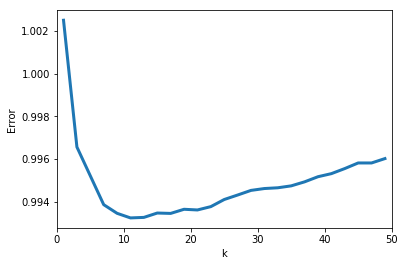

In [26]:
# Do some validation for the optimal value of k.
scores = []
ks = range(1, 50, 2)
for k in ks:
    Uk = u[:,0:k]
    Vk = v[0:k,:]
    Sk = s[:k]
    Tr_approx = np.dot(np.dot(Uk, np.diag(Sk)), Vk)
    Tr_approx
    scores.append(calc_score(Tr_approx, Ts))
fig, ax = plt.subplots()
ax.plot(ks, scores, linewidth=3)
ax.set_xlabel("k")
ax.set_ylabel("Error")
ax.set_xlim([0, 50])
plt.show()
# Results seem to favor low values of k between 8 and 15. Chosen: 10

In [6]:
s = {
    "max_iter": 31,
    "random_seed": 2895612,
    "max_neigh": 100,
    "num_factors": 15,
    "lrate_reduction": 0.9,
    "calc_train_score": 2,
    "test": True,
}

Iteration 0 took 26.10 seconds. training score: 1.0172576 - test score: 1.0225735
Iteration 1 took 22.50 seconds. training score: nan - test score: 1.0112889
Iteration 2 took 25.83 seconds. training score: 0.9983953 - test score: 1.0069233
Iteration 3 took 22.52 seconds. training score: nan - test score: 1.0047915
Iteration 4 took 26.03 seconds. training score: 0.9935312 - test score: 1.0036175
Iteration 5 took 22.71 seconds. training score: nan - test score: 1.0029179
Iteration 6 took 25.90 seconds. training score: 0.9914814 - test score: 1.0024764
Iteration 7 took 22.45 seconds. training score: nan - test score: 1.0021852
Iteration 8 took 25.98 seconds. training score: 0.9904047 - test score: 1.0019863
Iteration 9 took 24.06 seconds. training score: nan - test score: 1.0018465
Stopped because reached max iteration.


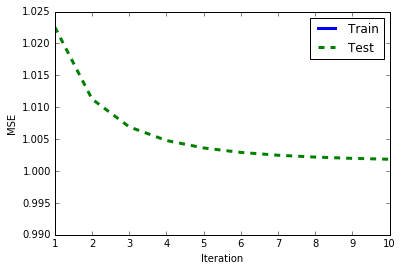

In [11]:
## Stochastic Gradient Descent --START--
s["max_iter"] = 10
np.random.seed(s["random_seed"])
tr_scores = []; ts_scores = []
lrate_bu = 3*10**(-3) # Parameter values come from BellJor2009
lrate_bi = 2*10**(-3)
regl_bu = 3*10**(-3)
regl_bi = 3*10**(-3)
lrate = 0.001
regl = 0.01
## Prepare the shuffled indices
indices = np.where(Tr != 0)
shuf_indices = list(range(len(indices[0])))
np.random.shuffle(shuf_indices)

user_vecs = np.random.normal(scale=1./s["num_factors"],\
                             size=(nusers, s["num_factors"]))
item_vecs = np.random.normal(scale=1./s["num_factors"],
                             size=(nitems, s["num_factors"]))
user_bias = np.zeros(nusers)
item_bias = np.zeros(nitems)
global_bias = np.mean(Tr[np.where(Tr != 0)])
def predict(u, i):
    return global_bias + user_bias[u] + item_bias[i] + \
                 user_vecs[u,:].dot(item_vecs[i,].T)
prev_score = None
for iteration in range(s["max_iter"]):
    start = time.clock()
    for q, iindex in enumerate(shuf_indices):
        u = indices[0][iindex]
        i = indices[1][iindex]

        prediction = predict(u, i)
        err = Tr[u, i] - prediction

        user_bias[u] += lrate_bu * (err - regl_bu * user_bias[u])
        item_bias[i] += lrate_bi * (err - regl_bi * item_bias[i])

        user_vecs[u,:] += lrate * (err * item_vecs[i,:] - regl * user_vecs[u,:])
        item_vecs[i,:] += lrate * (err * user_vecs[u,:] - regl * item_vecs[i,:])
    tr_score = np.nan
    if iteration % s["calc_train_score"] == 0:
        tr_score = calc_score_predict(Tr, predict)[0]
    tr_scores.append(tr_score)
    if Ts is not None and s["test"]:
        ts_score = calc_score_predict(Ts, predict)[0]; ts_scores.append(ts_score)
        stop_score = ts_score
    else:
        ts_score = np.nan
        stop_score = tr_score
    print("Iteration %d took %.2f seconds. training score: %.7f - test score: %.7f" % 
          (iteration, time.clock() - start, tr_score, ts_score))
    if prev_score is not None and not np.isnan(stop_score) and stop_score > prev_score:
        print("Stopping due to increase in test score.")
        break
    prev_score = stop_score
    lrate_bu = lrate_bu * s["lrate_reduction"]
    lrate_bi = lrate_bi * s["lrate_reduction"]
    lrate = lrate * s["lrate_reduction"]

if iteration == s["max_iter"]-1:
    print("Stopped because reached max iteration.")
plot_scores(tr_scores, ts_scores)
plt.show()

SGD_base_pred = get_predictor(Tr, Ts, predict)


array([-0.03518093,  0.01532792,  0.00106233,  0.05895361,  0.04511779,
        0.01059721,  0.06407626, -0.00943232, -0.04734726,  0.04892893,
       -0.0898168 ,  0.0417718 , -0.09368563, -0.061132  ,  0.13488777])

In [ ]:
Iteration 0 took 13.09 seconds. training score: nan - test score: 1.0225735
Iteration 1 took 15.73 seconds. training score: 1.0035926 - test score: 1.0109389
Iteration 2 took 16.37 seconds. training score: 0.9977268 - test score: 1.0064456
Iteration 3 took 15.77 seconds. training score: 0.9945815 - test score: 1.0042921
Iteration 4 took 14.12 seconds. training score: nan - test score: 1.0031443
Iteration 5 took 15.74 seconds. training score: 0.9914423 - test score: 1.0024904
Iteration 6 took 15.54 seconds. training score: 0.9905796 - test score: 1.0021002
Iteration 7 took 15.68 seconds. training score: 0.9899503 - test score: 1.0018596
Iteration 8 took 13.43 seconds. training score: nan - test score: 1.0017080
Iteration 9 took 15.75 seconds. training score: 0.9890982 - test score: 1.0016111
Iteration 10 took 15.44 seconds. training score: 0.9887961 - test score: 1.0015490
Iteration 11 took 15.66 seconds. training score: 0.9885467 - test score: 1.0015094
Iteration 12 took 13.56 seconds. training score: nan - test score: 1.0014849
Iteration 13 took 15.58 seconds. training score: 0.9881566 - test score: 1.0014703
Iteration 14 took 15.54 seconds. training score: 0.9880001 - test score: 1.0014625
Iteration 15 took 16.02 seconds. training score: 0.9878623 - test score: 1.0014595
Iteration 16 took 13.81 seconds. training score: nan - test score: 1.0014596
Stopping due to increase in test score.

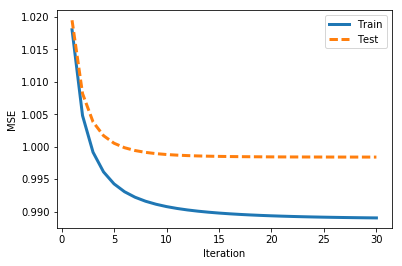

In [291]:
plot_scores(tr_scores, ts_scores)
plt.show()

Iteration 0 took 102.44 seconds. training score: 0.9954649 - test score: nan
Iteration 1 took 75.85 seconds. training score: nan - test score: nan
Iteration 2 took 76.51 seconds. training score: nan - test score: nan
Iteration 3 took 76.76 seconds. training score: nan - test score: nan
Iteration 4 took 78.30 seconds. training score: nan - test score: nan
Iteration 5 took 77.15 seconds. training score: nan - test score: nan
Iteration 6 took 77.87 seconds. training score: nan - test score: nan
Iteration 7 took 76.50 seconds. training score: nan - test score: nan
Iteration 8 took 76.58 seconds. training score: nan - test score: nan
Iteration 9 took 76.39 seconds. training score: nan - test score: nan
Iteration 10 took 105.44 seconds. training score: 0.9643543 - test score: nan
Iteration 11 took 75.22 seconds. training score: nan - test score: nan
Iteration 12 took 79.41 seconds. training score: nan - test score: nan
Iteration 13 took 80.07 seconds. training score: nan - test score: nan
It

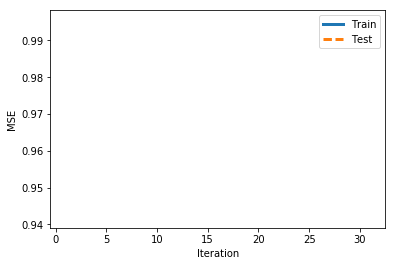

In [144]:
## SVD++
## From http://cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf
np.random.seed(s["random_seed"])
tr_scores = []; ts_scores = []
lrate1 = 0.007; lrate2 = 0.007  # Learning rate
regl6 = 0.005; regl7 = 0.015    # Regularization
## Prepare the shuffled indices
indices = np.where(Tr != 0)
shuf_indices = list(range(len(indices[0])))
np.random.shuffle(shuf_indices)

user_vecs = np.random.normal(scale=1./s["num_factors"],\
                             size=(nusers, s["num_factors"]))
item_vecs = np.random.normal(scale=1./s["num_factors"],
                             size=(nitems, s["num_factors"]))
user_bias = np.zeros(nusers)
item_bias = np.zeros(nitems)
y = np.zeros((nitems, s["num_factors"]))
global_bias = np.mean(Tr[np.where(Tr != 0)])
def predict(u, i):
    d = {}
    d["which_num_u"] = np.where(Tr[u,:] != 0)[0]
    d["num_u"] = 1/np.sqrt(len(d["which_num_u"]))
    d["sum_y"] = d["num_u"] * np.sum(y[d["which_num_u"]], axis=0) + user_vecs[u,:]
    d["prediction"] = global_bias + user_bias[u] + item_bias[i] + \
                            item_vecs[i,:].T.dot(d["sum_y"])
    return d

prev_score = None
for iteration in range(s["max_iter"]):
    start = time.process_time()
    lreg1 = lrate1 * regl6
    lreg2 = lrate2 * regl7
    for q, iindex in enumerate(shuf_indices):
        u = indices[0][iindex]
        i = indices[1][iindex]

        d = predict(u, i)
        lerr = lrate1 * (Tr[u, i] - d["prediction"])
        
        user_bias[u] += lerr - lreg1 * user_bias[u]
        item_bias[i] += lerr - lreg1 * item_bias[i]
        
        user_vecs[u,:] += lerr * item_vecs[i,:] - lreg2 * user_vecs[u,:]
        item_vecs[i,:] += lerr * d["sum_y"] - lreg2 * item_vecs[i,:]
        
        y[d["which_num_u"]] += lerr * item_vecs[i,:] * d["num_u"] - \
                                lreg2 * y[d["which_num_u"]]
    tr_score = np.nan
    if iteration % s["calc_train_score"] == 0:
        tr_score = calc_score_predict(Tr, lambda u,i: predict(u, i)["prediction"])[0]
    tr_scores.append(tr_score)
    if Ts is not None and s["test"]:
        ts_score = calc_score_predict(Ts, lambda u,i: predict(u, i)["prediction"])[0]; ts_scores.append(ts_score)
        stop_score = ts_score
    else:
        ts_score = np.nan
        stop_score = tr_score
    print("Iteration %d took %.2f seconds. training score: %.7f - test score: %.7f" % 
          (iteration, time.process_time() - start, tr_score, ts_score))
    if prev_score is not None and stop_score > prev_score:
        print("Stopping due to increase in test score.")
        break
    prev_score = stop_score
    lrate1 = lrate1 * s["lrate_reduction"]
    lrate2 = lrate2 * s["lrate_reduction"]

if iteration == s["max_iter"]-1:
    print("Stopped because reached max iteration.")
plot_scores(tr_scores, ts_scores)
plt.show()

SGD_simple_pred = get_predictor(Tr, Ts, lambda u,i: predict(u, i)["prediction"])


In [10]:
## Calculate similarity scores
def calc_s(i, j, l2, mat, corr_func):
    inter = np.intersect1d(np.where(mat[:,i] != 0)[0], np.where(mat[:,j] != 0)[0], True)
    n_ij = len(inter)
    if n_ij == 0: return 0
    p_ij = abs(corr_func(mat[inter,i], mat[inter, j])[0])
    return (n_ij / (n_ij + l2)) * p_ij
if False:
    print("Calculating Spearman correlation coefficient")
    start = time.process_time()
    # Upper triangular matrix of correlation coefficients
    corr_mat_spear = np.zeros((nitems, nitems))
    for i in range(nitems):
        for j in range(i+1, nitems):
            corr_mat_spear[i, j] = calc_s(i, j, 100, Tr, stats.spearmanr)
    # Make it full symmetric matrix
    corr_mat_spear = corr_mat_spear + corr_mat_spear.T
    print("Done in %.2f seconds" % (time.process_time() - start))

print("Calculating Pearson correlation coefficient")
start = time.process_time()
# Upper triangular matrix of correlation coefficients
corr_mat_pears = np.zeros((nitems, nitems))
for i in range(nitems):
    for j in range(i+1, nitems):
        corr_mat_pears[i, j] = calc_s(i, j, 100, Tr, stats.pearsonr)
# Make it full symmetric matrix
corr_mat_pears = corr_mat_pears + corr_mat_pears.T
print("Done in %.2f seconds" % (time.process_time() - start))

Calculating Pearson correlation coefficient


/home/gmeanti/venv/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Done in 94.76 seconds


Iteration 0 took 310.03 seconds (10 scoring). training score: 0.9908420 - test score: nan
Iteration 1 took 197.63 seconds (7. scoring). training score: nan - test score: nan
Iteration 2 took 189.87 seconds (7. scoring). training score: nan - test score: nan
Iteration 3 took 183.99 seconds (7. scoring). training score: nan - test score: nan
Iteration 4 took 198.21 seconds (7. scoring). training score: nan - test score: nan
Iteration 5 took 192.88 seconds (6. scoring). training score: nan - test score: nan
Iteration 6 took 204.38 seconds (7. scoring). training score: nan - test score: nan
Iteration 7 took 219.08 seconds (6. scoring). training score: nan - test score: nan
Iteration 8 took 213.90 seconds (7. scoring). training score: nan - test score: nan
Iteration 9 took 213.40 seconds (6. scoring). training score: nan - test score: nan
Iteration 10 took 320.26 seconds (11 scoring). training score: 0.9367552 - test score: nan
Iteration 11 took 197.46 seconds (7. scoring). training score: 

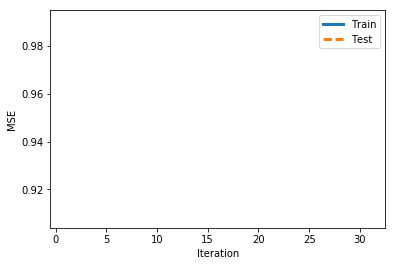

In [145]:
## Integrated
np.random.seed(s["random_seed"])
tr_scores = []; ts_scores = []
lrate1 = 0.007; lrate2 = 0.007; lrate3 = 0.001  # Learning rate
regl6 = 0.005; regl7 = 0.015; regl8 = 0.015;    # Regularization
## Set up the matrices
bias = Pc       # This is used for the neighbourhood model (contains fixed biases)
sim = corr_mat_spear  # Also used for neighbourhood. Pearson correlation coefficients between items
## Prepare the shuffled indices
tr_indices = np.where(Tr != 0)
shuf_indices = list(range(len(tr_indices[0])))
np.random.shuffle(shuf_indices)
## Initialize the empty vectors
user_vecs = np.random.normal(scale=1./s["num_factors"],\
                             size=(nusers, s["num_factors"]))
item_vecs = np.random.normal(scale=1./s["num_factors"],
                             size=(nitems, s["num_factors"]))
user_bias = np.zeros(nusers, dtype="float64")
item_bias = np.zeros(nitems, dtype="float64")
global_bias = np.mean(Tr[tr_indices])
y = np.zeros((nitems, s["num_factors"]), dtype="float64")
w = np.zeros((nitems, nitems), dtype="float64")
c = np.zeros((nitems, nitems), dtype="float64")

def predict(u, i):
    d = {}
    d["which_num_u"] = np.where(Tr[u,:] != 0)[0]
    num_u = len(d["which_num_u"])
    inv_kmax = max(0, num_u - s["max_neigh"])
    d["sqrt_num_u"] = 1 / np.sqrt(num_u)
    d["sum_y"] = user_vecs[u,:] + d["sqrt_num_u"]*np.sum(y[d["which_num_u"]], axis=0)

    ## Set of k items most similar to i intersect with the items rated by u
    ## Partial sort of top s["max_neigh"] items
    ii = np.argpartition(sim[i, d["which_num_u"]], inv_kmax)
    items = d["which_num_u"][ii[inv_kmax:]]

    d["topk"] = np.intersect1d(d["which_num_u"], items)
    d["n_topk"] = 1/np.sqrt(len(d["topk"]))
    
    neighbour_sum = np.sum((Tr[u,d["topk"]] - bias[u,d["topk"]])
                            * w[i,d["topk"]])
    implicit_sum = np.sum(c[i,d["topk"]])
    
    d["prediction"] = global_bias + user_bias[u] + item_bias[i] + \
                 item_vecs[i,:].T.dot(d["sum_y"]) + \
                 d["n_topk"] * neighbour_sum + \
                 d["n_topk"] * implicit_sum
            
    return d

prev_score = None
for iteration in range(s["max_iter"]):
    start = time.process_time()
    for q, iindex in enumerate(shuf_indices):
        u = tr_indices[0][iindex]
        i = tr_indices[1][iindex]

        d = predict(u, i)
        err = Tr[u, i] - d["prediction"]

        # Update values based on negative gradient
        prec1 = err * item_vecs[i,:]
        prec2 = err * d["n_topk"]
        user_bias[u] += lrate1 * (err - regl6 * user_bias[u])
        item_bias[i] += lrate1 * (err - regl6 * item_bias[i])
        user_vecs[u,:] += lrate2 * (prec1 - regl7 * user_vecs[u,:])
        item_vecs[i,:] += lrate2 * (err * d["sum_y"] - regl7 * item_vecs[i,:])

        y[d["which_num_u"]] += lrate2 * (prec1 * d["sqrt_num_u"] -
                                         regl7 * y[d["which_num_u"]])

        js = d["topk"]
        w[i,js] += lrate3 * (prec2 * (Tr[u,js] - bias[u,js]) - regl8 * w[i,js])
        c[i,js] += lrate3 * (prec2 - regl8 * c[i,js])
    it_time = time.process_time() - start
    tr_score = np.nan
    if iteration % s["calc_train_score"] == 0:
        tr_score = calc_score_predict(Tr, lambda u,i: predict(u, i)["prediction"])[0]
    tr_scores.append(tr_score)
    if Ts is not None and s["test"]:
        ts_score = calc_score_predict(Ts, lambda u,i: predict(u, i)["prediction"])[0]; ts_scores.append(ts_score)
        stop_score = ts_score
    else:
        ts_score = np.nan
        stop_score = tr_score
    score_time = time.process_time() - start - it_time
    print("Iteration %d took %.2f seconds (%.2fs scoring). training score: %.7f - test score: %.7f" % 
          (iteration, time.process_time() - start, score_time, tr_score, ts_score))
    if prev_score is not None and stop_score > prev_score:
        print("Stopping due to increase in test score.")
        break
    prev_score = stop_score
    lrate1 *= s["lrate_reduction"]
    lrate2 *= s["lrate_reduction"]
    lrate3 *= s["lrate_reduction"]

if iteration == s["max_iter"]-1:
    print("Stopped because reached max iteration.")
plot_scores(tr_scores, ts_scores)
plt.show()

SGD_integrated_pred = get_predictor(Tr, Ts, lambda u,i: predict(u, i)["prediction"])


In [26]:
a = [1, 2, 3, 4, 5]
a[-10:]
    #expl_items = np.intersect1d(d["which_num_u"], d["which_num_u"][sim_sorted[-s["max_neigh"]:]])

np.argpartition(sim[i, :], s["max_neigh"]).size

1000

In [22]:
## Only Neighbourhood Model (solve with least squares)
# http://cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf
# pages 4,5
s["max_neigh"] = 250
np.random.seed(s["random_seed"])
tr_scores = []; ts_scores = []
lrate = 0.005   # Learning rate
regl4 = 0.003   # Regularization
## Set up the matrices
bias = Pc       # This is used for the neighbourhood model (contains fixed biases)
sim  = corr_mat_pears # Also used for neighbourhood. Pearson correlation coefficients between items
## Prepare the shuffled indices
tr_indices = np.where(Tr != 0)
shuf_indices = list(range(len(tr_indices[0])))
np.random.shuffle(shuf_indices)
## Initialize the empty vectors
user_bias = np.zeros(nusers, dtype="float64")
item_bias = np.zeros(nitems, dtype="float64")
global_bias = np.mean(Tr[tr_indices])
w = np.zeros((nitems, nitems), dtype="float64")
c = np.zeros((nitems, nitems), dtype="float64")

def predict(u, i):
    d = {}
    d["which_num_u"] = np.where(Tr[u,:] != 0)[0]
    d["implicit_u"] = np.where(imp_mask[u,:] != 0)[0]
    inv_kmax_expl = max(0, len(d["which_num_u"]) - s["max_neigh"])
    inv_kmax_impl = max(0, len(d["implicit_u"]) - s["max_neigh"])

    ## Set of k items most similar to i:
    ksim_expl = np.argpartition(sim[i, d["which_num_u"]], inv_kmax_expl)
    ksim_impl = np.argpartition(sim[i, d["implicit_u"]], inv_kmax_impl)
    
    #d["expl_items"] = np.intersect1d(d["which_num_u"], d["which_num_u"][ksim_expl[inv_kmax_expl:]])
    d["expl_items"] = d["which_num_u"][ksim_expl[inv_kmax_expl:]]
    d["n_expl"] = 1 / np.sqrt(len(d["expl_items"]))
    
    #d["impl_items"] = np.intersect1d(d["implicit_u"], d["implicit_u"][ksim_impl[inv_kmax_impl:]])
    d["impl_items"] = d["implicit_u"][ksim_impl[inv_kmax_impl:]]
    d["n_impl"] = 1 / np.sqrt(len(d["impl_items"]))
    
    ## Set of k items most similar to i intersect with the items rated by u
    ## Partial sort of top s["max_neigh"] items
    #ii = np.argpartition(sim[i, d["which_num_u"]], inv_kmax)
    #items = d["which_num_u"][ii[inv_kmax:]]

    #d["topk"] = np.intersect1d(d["which_num_u"], items)
    #d["n_topk"] = 1/np.sqrt(len(d["topk"]))

    neighbour_sum = np.sum((Tr[u,d["expl_items"]] - bias[u,d["expl_items"]])
                            * w[i,d["expl_items"]])
    implicit_sum = np.sum(c[i,d["impl_items"]])

    d["prediction"] = global_bias + user_bias[u] + item_bias[i] + \
                 d["n_expl"] * neighbour_sum + \
                 d["n_impl"] * implicit_sum
    return d

prev_score = None
for iteration in range(s["max_iter"]):
    start = time.process_time()
    for q, iindex in enumerate(shuf_indices):
        u = tr_indices[0][iindex]
        i = tr_indices[1][iindex]

        d = predict(u, i)
        err = Tr[u, i] - d["prediction"]

        # Update values based on negative gradient
        user_bias[u] += lrate * (err - regl4 * user_bias[u])
        item_bias[i] += lrate * (err - regl4 * item_bias[i])
        ei = d["expl_items"]
        w[i,ei] += lrate * (err * d["n_expl"] * (Tr[u, ei] - bias[u, ei]) -
                            regl4 * w[i,ei])
        c[i,d["impl_items"]] += lrate * (err * d["n_impl"] - regl4 * c[i,d["impl_items"]])
    
    # Timing and scoring bs
    it_time = time.process_time() - start
    tr_score = np.nan
    if iteration % s["calc_train_score"] == 0:
        tr_score = calc_score_predict(Tr, lambda u,i: predict(u, i)["prediction"])[0]
    tr_scores.append(tr_score)
    if Ts is not None and s["test"]:
        ts_score = calc_score_predict(Ts, lambda u,i: predict(u, i)["prediction"])[0]; ts_scores.append(ts_score)
        stop_score = ts_score
    else:
        ts_score = np.nan
        stop_score = tr_score
    score_time = time.process_time() - start - it_time
    print("Iteration %d took %.2f seconds (%.2fs scoring). training score: %.7f - test score: %.7f" % 
          (iteration, time.process_time() - start, score_time, tr_score, ts_score))
    if prev_score is not None and stop_score > prev_score:
        print("Stopping due to increase in test score.")
        #break
    prev_score = stop_score
    lrate *= s["lrate_reduction"]

if iteration == s["max_iter"]-1:
    print("Stopped because reached max iteration.")
plot_scores(tr_scores, ts_scores)
plt.show()
    
SGD_neighbour_pred = get_predictor(Tr, Ts, lambda u,i: predict(u, i)["prediction"])


Iteration 0 took 123.83 seconds (51.63s scoring). training score: 0.9258657 - test score: 1.0062781
Iteration 1 took 81.31 seconds (10.40s scoring). training score: nan - test score: 0.9977350
Iteration 2 took 119.97 seconds (48.59s scoring). training score: 0.8109887 - test score: 0.9942352
Iteration 3 took 82.48 seconds (10.03s scoring). training score: nan - test score: 0.9923046
Iteration 4 took 120.92 seconds (49.44s scoring). training score: 0.7443819 - test score: 0.9910584
Iteration 5 took 80.19 seconds (9.38s scoring). training score: nan - test score: 0.9901789
Iteration 6 took 120.45 seconds (49.28s scoring). training score: 0.7006045 - test score: 0.9895238
Iteration 7 took 82.68 seconds (10.84s scoring). training score: nan - test score: 0.9890182
Iteration 8 took 120.18 seconds (48.47s scoring). training score: 0.6701202 - test score: 0.9886182
Iteration 9 took 79.68 seconds (9.81s scoring). training score: nan - test score: 0.9882960
Iteration 10 took 117.10 seconds (46.

KeyboardInterrupt: 

In [ ]:
Iteration 0 took 182.55 seconds (74.18s scoring). training score: 0.9724530 - test score: nan
Iteration 1 took 103.59 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 2 took 104.37 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 3 took 110.42 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 4 took 104.93 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 5 took 106.33 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 6 took 119.29 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 7 took 104.61 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 8 took 104.37 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 9 took 103.06 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 10 took 174.37 seconds (71.38s scoring). training score: 0.8616350 - test score: nan
Iteration 11 took 102.55 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 12 took 102.11 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 13 took 102.25 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 14 took 102.18 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 15 took 102.17 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 16 took 102.44 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 17 took 102.56 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 18 took 102.92 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 19 took 104.98 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 20 took 172.77 seconds (67.56s scoring). training score: 0.8380279 - test score: nan
Iteration 21 took 103.31 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 22 took 104.43 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 23 took 103.94 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 24 took 103.51 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 25 took 103.26 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 26 took 104.69 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 27 took 105.27 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 28 took 106.80 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 29 took 106.23 seconds (0.00s scoring). training score: nan - test score: nan
Iteration 30 took 178.12 seconds (70.18s scoring). training score: 0.8306742 - test score: nan
Stopped because reached max iteration.


## Neighbourhood model

Similarity between two items i, j: $s_{i,j} = \dfrac{n_{ij}}{n_{ij} + \lambda_2}\rho_{ij}$
with $\lambda_2 = 100$, $\rho_{ij}$ is the pearson correlation coefficient which only takes into account the users who have rated both items. $n_{ij}$ is the number of users who have rated both items



In [147]:
k = 100
# Prediction function
def predict(u, i, mat, base, sim):
    # fetch the k items rated by user u, which are most similar to i
    items = np.where(mat[u,:] != 0)[0]
    items = sorted(items, key=lambda j: sim[i, j], reverse=True)[:k]
    try:
        indexi = items.index(i)
        del items[indexi]
    except ValueError: pass
    numer = sum([sim[i, j]*(mat[u,j] - base[u,j]) for j in items])
    denom = sum([sim[i, j] for j in items])
    return base[u, i] + numer / denom

print("Computing Spearman predictor")
start = time.process_time()
predict_part = functools.partial(predict, mat=Tr, base=Pc, sim=corr_mat_spear)
neigh_spearman_pred = get_predictor(Tr, Ts, predict_part)
print("Took %.2f seconds" % (time.process_time() - start))

print("Computing Pearson predictor")
start = time.process_time()
predict_part = functools.partial(predict, mat=Tr, base=Pc, sim=corr_mat_pears)
neigh_pearson_pred = get_predictor(Tr, Ts, predict_part)
print("Took %.2f seconds" % (time.process_time() - start))

Computing Spearman predictor
Took 706.75 seconds
Computing Pearson predictor
Took 623.76 seconds


In [267]:
pindices = np.where(Ts != 0)
P = np.zeros_like(Tr, dtype="float64")
lastP = 0
for i in range(len(pindices[0])):
    p = int(i / len(pindices[0]) * 100)
    if p - lastP > 9:
        print("%d%% done" % p)
        lastP = p
    
    u = pindices[0][i]
    i = pindices[1][i]
    P[u, i] = predict_part(u, i)
    
print("Score: %f" % calc_score(P, Ts, Mts))

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
Score: 0.991344


In [2]:
import xgboost as xgb

/home/gmeanti/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
load_from_disk = True
if load_from_disk:
    d_train = xgb.DMatrix("../saved_data/train.buffer")
    d_valid = xgb.DMatrix("../saved_data/valid.buffer")
else:
    # Create the feature vectors
    predictors = [neigh_spearman_pred, neigh_pearson_pred, bias_predictor, 
                  SVD_predictor, SGD_simple_pred, SGD_neighbour_pred, 
                  SGD_integrated_pred, SGD_base_pred]
    x_train = np.vstack((predictors[0][0], predictors[1][0], predictors[2][0], 
                         predictors[3][0], predictors[4][0], predictors[5][0],
                         predictors[6][0], predictors[7][0])).T
    y_train = Tr[np.where(Tr != 0)]
    x_test = np.vstack((predictors[0][1], predictors[1][1], predictors[2][1], 
                        predictors[3][1], predictors[4][1], predictors[5][1],
                        predictors[6][1], predictors[7][1])).T
    y_test = None
    if s["test"]:
        y_test = Ts[np.where(Ts != 0)]
    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_test, label=y_test)
    # Save data
    d_train.save_binary("saved_data/train.buffer")
    d_valid.save_binary("saved_data/valid.buffer")

In [10]:
import xgboost as xgb

params = {}
params['objective'] = "reg:linear"
#params['base_score'] = global_mean
params['eval_metric'] = "rmse"
params['seed'] = 12390
params['eta'] = 0.1
params['max_depth'] = 3
params['alpha'] = 10
params['lambda'] = 10
params['subsample'] = 0.9
num_round = 250
early_stop = 20

watchlist = [(d_train, 'train')]
if False:
    watchlist.append((d_valid, 'valid'))
# Perform training.
bst = xgb.train(params, d_train, num_round, watchlist, early_stopping_rounds=early_stop, verbose_eval=10)

[0]	train-rmse:3.20468
Will train until train-rmse hasn't improved in 20 rounds.
[10]	train-rmse:1.33043
[20]	train-rmse:0.834601
[30]	train-rmse:0.740582
[40]	train-rmse:0.720245
[50]	train-rmse:0.713047
[60]	train-rmse:0.708593
[70]	train-rmse:0.70511
[80]	train-rmse:0.702229
[90]	train-rmse:0.70066
[100]	train-rmse:0.698776
[110]	train-rmse:0.697871
[120]	train-rmse:0.696755
[130]	train-rmse:0.69562
[140]	train-rmse:0.69466
[150]	train-rmse:0.693947
[160]	train-rmse:0.693221
[170]	train-rmse:0.692262
[180]	train-rmse:0.69172
[190]	train-rmse:0.69102
[200]	train-rmse:0.690518
[210]	train-rmse:0.690025
[220]	train-rmse:0.689462
[230]	train-rmse:0.689041
[240]	train-rmse:0.688636


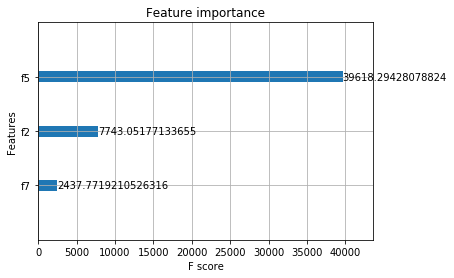

In [181]:
xgb.plot_importance(bst, importance_type="gain")#, max_num_features=None)
plt.show()

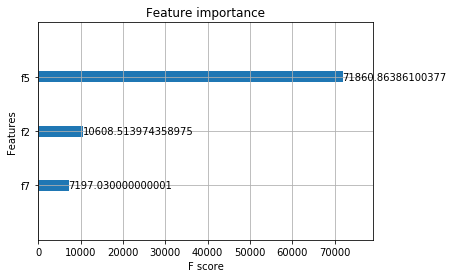

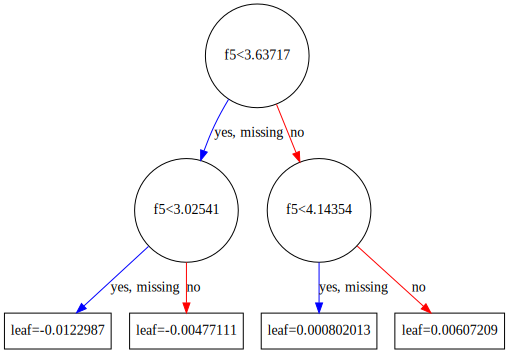

In [177]:
xgb.plot_importance(bst, importance_type="gain")#, max_num_features=None)
plt.show()
xgb.to_graphviz(bst, num_trees=8)

In [22]:
import numpy as np
# Make predictions
ypred = bst.predict(d_valid)
submit_file = "../saved_data/xgboost_predict_mistery.csv"
#print("Training error: %f" % score)
print("Writing results")
with open(submit_file, 'w') as fh:
    fh.write("Id,Prediction\n")
    indices = np.where(Ts != 0)
    for index in range(len(indices[0])):
        u = indices[0][index]
        i = indices[1][index]
        fh.write("r%d_c%d,%f\n" % (u+1, i+1, ypred[index]))

Writing results


In [163]:
index

1176951

In [47]:
### BLENDING WITH BOOSTED REGRESSION
has_test = False
X_train = np.vstack((neigh_spearman_pred[0], neigh_pearson_pred[0], bias_predictor[0], 
                     SVD_predictor[0], SGD_simple_pred[0], SGD_neighbour_pred[0])).T
X_test = np.vstack((neigh_spearman_pred[1], neigh_pearson_pred[1], bias_predictor[1], 
                    SVD_predictor[1], SGD_simple_pred[1], SGD_neighbour_pred[1])).T
y_train = Tr[np.where(Tr != 0)]
def monitor(i, est, other):
    print("%d iteration" % i)
    if i > 40:
        return True # Stop regressor
if has_test:
    y_test = Ts[np.where(Ts != 0)]
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2,
    max_depth=20, random_state=0, loss='ls').fit(X_train, y_train, monitor=monitor)
if has_test:
    score = np.sqrt(mean_squared_error(y_test, est.predict(X_test)))
    print("Score: %f" % score)
else:
    pred = est.predict(X_test)
    score = np.sqrt(mean_squared_error(y_train, pred))
    print("Training error: %f" % score)
    print("Writing results")
    with open(submit_file, 'w') as fh:
        fh.write("Id,Prediction\n")
        indices = np.where(Ts != 0)
        for index in range(len(indices[0])):
            u = indices[0][index]
            i = indices[1][index]
            fh.write("r%d_c%d,%f\n" % (u+1, i+1, pred[index]))


KeyboardInterrupt: 

In [40]:
print("Writing results")
pred = SGD_neighbour_pred[1]
with open(submit_file, 'w') as fh:
    fh.write("Id,Prediction\n")
    indices = np.where(Ts != 0)
    for index in range(len(indices[0])):
        u = indices[0][index]
        i = indices[1][index]
        fh.write("r%d_c%d,%f\n" % (u+1, i+1, pred[index]))
print("Done")


Writing results
Done


0.67602626902105312